In [2]:
# primitive
import sys
import os
import pickle
import itertools
from joblib import Parallel, delayed
from pprint import pprint
import itertools
from collections import Counter
from time import time

# data handling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# text
import MeCab
import spacy
import gensim
from gensim.models import KeyedVectors

# nn
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchtext.vocab import Vocab

# **
# handmade libs
# *
src = '../../src'
if src not in sys.path: sys.path.append(src)

# constants
from const import *
constants = {k: v for k, v in locals().items() if k.isupper()}
pprint(constants)

# modules
from my_tokenizer import get_tokenizer
from livedoor_dataset import LivedoorDataset
from myutils import get_n_label

{'DEVICE': 'cuda',
 'DIR_BIN': '/tmp/work/livedoor/bin',
 'DIR_DATA': '/tmp/work/livedoor/data',
 'DIR_LOG': '/tmp/work/livedoor/log',
 'DIR_MECAB_DIC': '/usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd',
 'DIR_MODEL': '/tmp/work/livedoor/model',
 'ROOT': '/tmp/work/livedoor',
 'SAMPLE_SENT': 'ワンマンライブに行きたい。',
 'SEED': 123,
 'TOKENIZER': 'mecab'}


# Load

In [3]:
# データセット読み込み
file = os.path.join(DIR_BIN, 'train_subset.pkl')
with open(file, 'rb') as f:
    train_dataset = pickle.load(f)

file = os.path.join(DIR_BIN, 'test_subset.pkl')
with open(file, 'rb') as f:
    test_dataset = pickle.load(f)

# vocab 読み込み
TOKENIZER = 'sudachi'
DICT = 'core'
EMBEDDING = 'chive_mc90'
file_vocab = os.path.join(DIR_BIN, f'vocab.{TOKENIZER}.{DICT}.{EMBEDDING}.pkl')
with open(file_vocab, 'rb') as f:
    vocab = pickle.load(f)

display(get_n_label(train_dataset).style.background_gradient('Blues', axis=1))
display(get_n_label(test_dataset).style.background_gradient('Blues', axis=1))
len(vocab)

0,0,1,2,3,4,5,6,7,8
1,698,687,690,392,675,688,632,732,699


0,0,1,2,3,4,5,6,7,8
1,172,183,173,119,195,154,138,168,171


76023

In [4]:
PAD = vocab.stoi['<pad>']
UNK = vocab.stoi['<unk>']

# Experiments

指定した文の分散表現


<AxesSubplot:>

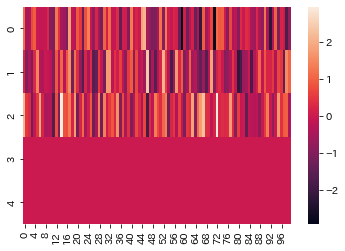

In [5]:
class RandomEmbedding(nn.Module):
    
    def __init__(self, vocab_size, embed_dim):
        super(RandomEmbedding, self).__init__()
        torch.manual_seed(SEED)
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab.stoi['<pad>'])
        self.embedding.weight.requires_grad = False
    
    def forward(self, texts):
        return self.embedding(texts)

random_emb = RandomEmbedding(len(vocab), 100)
emb = random_emb(torch.tensor([[2, 3, 4, 5, 6],
                               [2, 3, 4, 1, 1]])).detach().numpy()[1]
print('指定した文の分散表現')
display(sns.heatmap(emb))

[37546 14928 38079 67033 13380 62515 38481 46086 55949 15705 54819 63046
 54058 48404 35041 38746 68067 54777 22069 49639 31887 29473 38211  7888
 60441 18973 18635 39936 18068  2570 46617 29676 37000 56132 21313 70919
 10885 67769 43640  3862 18589 23114 66827 22113 66567 47107 33684   944
 68605  6672 15077 67447 15834 48827 52914 56309 15157 15315 21739  1332
 60562 52319 26585 16239 26539  8359 25538 72886 38030 37490 68623 74379
 34160 63230  9741 58854 57749 56390 50326 29240 25242 57646 75927 61136
 39755 12670 70577  7415 16278 18758 22295 46963 38690 37762 45037 45494
 26948 39266 70110  5886  3856 37781 59978 18311 73298 71659 37782  9468
 69386 72174 61246 71673 62035 41304 44309 39339 42991 40622 61322 13965
 13751 51347 28178 58307  1995 44781 17680 56729 30726 22341 47659 46649
 52037 35410 53355 30665 37509 63253 75892 44858 75376 75952  2568 43511
 26852 20276 14556 66891  1143 28920  5738 22348 11242 73858 21930 66054
  2578 49634   266 59912 12156 75179 66995 60274 55

<AxesSubplot:>

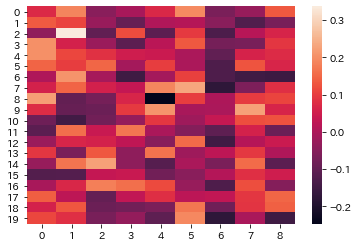

In [6]:
class LSTMClassifier(nn.Module):
    
    def __init__(self, vocab_size, embed_dim, h_dim, class_dim):
        super(LSTMClassifier, self).__init__()
        torch.manual_seed(SEED)
        self.embedding = RandomEmbedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, h_dim, batch_first=True)
        self.linear = nn.Linear(h_dim, class_dim)
        
    def forward(self, texts):
        emb = self.embedding(texts)
        o, (h_n, c_n) = self.lstm(emb)
        out = self.linear(h_n)
        return out

lstm = LSTMClassifier(len(vocab), 300, 100, 9)
input_ = torch.tensor(np.random.randint(0, 76023, [20, 300]))
print(input_.detach().numpy()[0])
output = lstm(input_).detach().squeeze().numpy()
print('output')
sns.heatmap(output, annot=False)

In [7]:
# 初期化時点のモデル output の偏り
# osx だと満遍なく出力される；Ubuntu18.04 だと一つのラベルに偏る？ Ubuntu20.04 だと解消されてたりしない？
freq = Counter(output.argmax(axis=1)).most_common()
pd.DataFrame(freq).set_index(0).style.background_gradient('Blues')

,1
0,
5,5
0,4
2,3
1,2
7,2
8,2
3,1
4,1


In [8]:
# 対応付が間違っているのではないか？check①
# → OK; 系列長が一致する
print(len(vocab))
emb = [p for p in next(lstm.embedding.parameters())]
print(len(emb))

76023
76023


In [9]:
# 対応付が間違っているのではないか？check②
# OK; pad index に対応するのはそれぞれ <pad> トークンと zero ベクトル
print(vocab.itos[PAD])
print(emb[PAD])

<pad>
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [10]:
tokenizer = get_tokenizer('sudachi')

In [11]:
# sentense2index
text_pipeline = lambda text: [vocab.stoi[str(token)] for token in tokenizer(text)]

In [13]:
# トークナイザー高速化すれば、学習実施できる

In [12]:
# train
def iter_train(dataloader, model, loss_fn, optimizer):
    current_size = 0
    current_loss, current_correct = 0, 0
    
    for batch, (labels, texts) in enumerate(dataloader):
        
        # indexing
        texts = [torch.tensor(text_pipeline(text)) for text in texts]
        texts = pad_sequence(texts, batch_first=True, padding_value=PAD)
            
        # send to GPU
        labels, texts = labels.to(DEVICE), texts.to(DEVICE)

        # pred
        pred = model(texts)[0]

        # get loss
        loss = loss_fn(pred, labels)

        # get gradient
        optimizer.zero_grad() # バッチごとに勾配をリセット
        loss.backward()

        # back propagate
        # 手動；todo: optimizer.step() の動作確認，デバッグ
        for layer_num, param in enumerate(model.parameters()):
            if layer_num==0:
                continue
            LR = optimizer.state_dict()['param_groups'][0]['lr']
            param.data -= LR * param.grad.data # 正負間違えてるとかないよね
#         optimizer.step()
        
        current_size += len(labels)
        current_loss += loss.item()
        current_correct += (pred.argmax(axis=1).squeeze()==labels).type(torch.int).sum().item()
        
        mean_loss = current_loss/current_size
        mean_correct = current_correct/current_size

        # logging
        if batch%30==0 and batch!=0:
            split = 'train'
            print(f'| {split*(1 if batch==0 else 0):5} | batch {batch:3d} '
                  f'| correct total: {mean_correct:0.8f} | loss total: {mean_loss:0.8f} |')
    
    return mean_correct, mean_loss

if DEVICE=='cuda':
    # 1 epoch sample execution
    sample_dataloader = DataLoader(train_dataset,
                                   batch_size=64,
                                   shuffle=False,)
    LR = 1e-4
    model = LSTMClassifier(len(vocab), 300, 100, 9).to(DEVICE)
    loss_fn = nn.CrossEntropyLoss().to(DEVICE)
    optimizer = torch.optim.SGD(model.parameters(), lr=LR)
    iter_train(sample_dataloader, model, loss_fn, optimizer)

KeyboardInterrupt: 

In [11]:
# validate
def iter_test(dataloader, model, loss_fn):
    test_size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        # 全ての勾配計算を無効化
        for batch, (labels, texts) in enumerate(dataloader):
            
            # indexing
            texts = [torch.tensor(text_pipeline(text)) for text in texts]
            texts = pad_sequence(texts, batch_first=True, padding_value=PAD)
            
            # send to GPU
            labels, texts = labels.to(DEVICE), texts.to(DEVICE)
            
            # predict
            pred = model(texts)[0]

            # get loss
            test_loss += loss_fn(pred, labels).item()

            # eval
            pred_labels = pred.argmax(axis=1).squeeze() # この squeeze は問題ないのか？
            correct += (pred_labels==labels).type(torch.int).sum().item()

    correct /= test_size # Epoch 終了時点の Accuracy（正答数 / テストサンプルサイズ）
    test_loss /= test_size # Epoch 終了時点の 1 サンプルあたり Loss 平均（Loss / テストサンプルサイズ）

    split = 'test'
    print(f'| {split:5} | accuracy: {correct:0.4f} | loss avg: {test_loss:6.8f} |', end='')
    
    return correct, test_loss

if DEVICE=='cuda':
    # sample execution
    sample_dataloader = DataLoader(test_dataset,
                                   batch_size=64,
                                   shuffle=False,)
    LR = 1e-2
    model = LSTMClassifier(len(vocab), 300, 100, 9).to(DEVICE)
    loss_fn = nn.CrossEntropyLoss().to(DEVICE)
    optimizer = torch.optim.SGD(model.parameters(), lr=LR)
    iter_test(sample_dataloader, model, loss_fn)

| test  | accuracy: 0.1032 | loss avg: 0.03583317 |

Execute

In [12]:
# model setting
model_name = 'lstm'
embed_type = 'random'
embed_dim = 300
hidden_dim = 100

# training setting
batchsizes = [32]
lrs = [1e-1]
mos = [0.9]
n_epochss = [100]

for (batchsize, lr, mo, n_epochs) in itertools.product(batchsizes, lrs, mos, n_epochss):
    # dataloader
    train_dataloader = DataLoader(train_dataset,
                                  batch_size=batchsize,
                                  shuffle=True,)

    test_dataloader = DataLoader(test_dataset,
                                  batch_size=batchsize,
                                  shuffle=True,)

    # define network architecture
    model = LSTMClassifier(len(vocab), embed_dim, hidden_dim, 9).to(DEVICE)
    
    # modules
    loss_fn = nn.CrossEntropyLoss().to(DEVICE)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=mo)
    
    # train model
    result = []
    start = time()
    for epoch in range(n_epochs):

        print(f'{"-"*28} Epoch {epoch} {"-"*28}')
        train_acc, train_loss = iter_train(train_dataloader, model, loss_fn, optimizer)
        test_acc, test_loss = iter_test(test_dataloader, model, loss_fn)
        print(f' {time()-start:5.2f} sec |')
        result.append((epoch, train_acc, train_loss, test_acc, test_loss))

    print('done!')
    
    # **
    # save
    # *
    filename_base = f'emb={embed_type}&edim={embed_dim:03d}' \
                    f'&model={model_name}&hdim={hidden_dim:03d}' \
                    f'&batchsize={batchsize:03d}' \
                    f'&optim=sgd&lr={lr:.5f}&mo={mo:.1f}' \
                    f'&epochs={n_epochs:4d}' \
                    f'&shuffle=True'
    filename_model = os.path.join(DIR_MODEL, filename_base+'.pth')
    filename_log = os.path.join(DIR_LOG, filename_base+'.csv')

    # save model
    if not os.path.isfile(filename_model):
        torch.save(model, filename_model)
        print(f'{filename_model} : created')
    else:
        print(f'{filename_model} : exists')

    # save log
    if not os.path.isfile(filename_log):
        result = pd.DataFrame(result).rename(columns={0: 'epoch',
                                                      1: 'train_acc',
                                                      2: 'train_loss',
                                                      3: 'test_acc',
                                                      4: 'test_loss'})
        result.to_csv(filename_log, index=False)
        print(f'{filename_log} : created')
    else:
        print(f'{filename_log} : exists')

---------------------------- Epoch 0 ----------------------------
|       | batch  30 | correct total: 0.09979839 | loss total: 0.06870372 |
|       | batch  60 | correct total: 0.10604508 | loss total: 0.06860261 |
|       | batch  90 | correct total: 0.10405220 | loss total: 0.06854581 |
|       | batch 120 | correct total: 0.10847107 | loss total: 0.06850113 |
|       | batch 150 | correct total: 0.11196192 | loss total: 0.06844615 |
|       | batch 180 | correct total: 0.11861188 | loss total: 0.06836882 |
| test  | accuracy: 0.1195 | loss avg: 0.06977707 | 51.59 sec |
---------------------------- Epoch 1 ----------------------------
|       | batch  30 | correct total: 0.11693548 | loss total: 0.06842511 |
|       | batch  60 | correct total: 0.13217213 | loss total: 0.06823190 |
|       | batch  90 | correct total: 0.12568681 | loss total: 0.06813983 |
|       | batch 120 | correct total: 0.13248967 | loss total: 0.06812349 |
|       | batch 150 | correct total: 0.13327815 | loss

|       | batch  30 | correct total: 0.13104839 | loss total: 0.06713116 |
|       | batch  60 | correct total: 0.14036885 | loss total: 0.06710721 |
|       | batch  90 | correct total: 0.13427198 | loss total: 0.06706669 |
|       | batch 120 | correct total: 0.13842975 | loss total: 0.06714698 |
|       | batch 150 | correct total: 0.13907285 | loss total: 0.06712833 |
|       | batch 180 | correct total: 0.13777624 | loss total: 0.06711923 |
| test  | accuracy: 0.1317 | loss avg: 0.06823461 | 767.89 sec |
---------------------------- Epoch 15 ----------------------------
|       | batch  30 | correct total: 0.15725806 | loss total: 0.06739320 |
|       | batch  60 | correct total: 0.14190574 | loss total: 0.06732751 |
|       | batch  90 | correct total: 0.13873626 | loss total: 0.06730462 |
|       | batch 120 | correct total: 0.14049587 | loss total: 0.06715057 |
|       | batch 150 | correct total: 0.13907285 | loss total: 0.06712671 |
|       | batch 180 | correct total: 0.1414

|       | batch  60 | correct total: 0.14600410 | loss total: 0.06661692 |
|       | batch  90 | correct total: 0.14388736 | loss total: 0.06676784 |
|       | batch 120 | correct total: 0.14669421 | loss total: 0.06676499 |
|       | batch 150 | correct total: 0.14755795 | loss total: 0.06673174 |
|       | batch 180 | correct total: 0.14882597 | loss total: 0.06669942 |
| test  | accuracy: 0.1378 | loss avg: 0.06973346 | 1484.89 sec |
---------------------------- Epoch 29 ----------------------------
|       | batch  30 | correct total: 0.14213710 | loss total: 0.06666962 |
|       | batch  60 | correct total: 0.14754098 | loss total: 0.06654772 |
|       | batch  90 | correct total: 0.14182692 | loss total: 0.06659339 |
|       | batch 120 | correct total: 0.14204545 | loss total: 0.06662123 |
|       | batch 150 | correct total: 0.14362583 | loss total: 0.06665968 |
|       | batch 180 | correct total: 0.14554558 | loss total: 0.06663151 |
| test  | accuracy: 0.1371 | loss avg: 0.0

|       | batch  90 | correct total: 0.13358516 | loss total: 0.06643648 |
|       | batch 120 | correct total: 0.13403926 | loss total: 0.06643014 |
|       | batch 150 | correct total: 0.13410596 | loss total: 0.06645534 |
|       | batch 180 | correct total: 0.13535912 | loss total: 0.06645938 |
| test  | accuracy: 0.1358 | loss avg: 0.06864580 | 2200.55 sec |
---------------------------- Epoch 43 ----------------------------
|       | batch  30 | correct total: 0.16028226 | loss total: 0.06646713 |
|       | batch  60 | correct total: 0.14959016 | loss total: 0.06634947 |
|       | batch  90 | correct total: 0.14697802 | loss total: 0.06639752 |
|       | batch 120 | correct total: 0.14695248 | loss total: 0.06643059 |
|       | batch 150 | correct total: 0.14797185 | loss total: 0.06649540 |
|       | batch 180 | correct total: 0.14640884 | loss total: 0.06649175 |
| test  | accuracy: 0.1507 | loss avg: 0.06709253 | 2252.35 sec |
---------------------------- Epoch 44 -------------

|       | batch 120 | correct total: 0.15599174 | loss total: 0.06643444 |
|       | batch 150 | correct total: 0.15231788 | loss total: 0.06639110 |
|       | batch 180 | correct total: 0.15003453 | loss total: 0.06641311 |
| test  | accuracy: 0.1351 | loss avg: 0.07001772 | 2918.34 sec |
---------------------------- Epoch 57 ----------------------------
|       | batch  30 | correct total: 0.16129032 | loss total: 0.06660132 |
|       | batch  60 | correct total: 0.15573770 | loss total: 0.06647793 |
|       | batch  90 | correct total: 0.14938187 | loss total: 0.06643094 |
|       | batch 120 | correct total: 0.14953512 | loss total: 0.06640308 |
|       | batch 150 | correct total: 0.14921358 | loss total: 0.06643915 |
|       | batch 180 | correct total: 0.14692680 | loss total: 0.06646080 |
| test  | accuracy: 0.1236 | loss avg: 0.06753525 | 2969.04 sec |
---------------------------- Epoch 58 ----------------------------
|       | batch  30 | correct total: 0.14818548 | loss tota

|       | batch 150 | correct total: 0.15521523 | loss total: 0.06638498 |
|       | batch 180 | correct total: 0.15314227 | loss total: 0.06640568 |
| test  | accuracy: 0.1534 | loss avg: 0.06734338 | 3632.38 sec |
---------------------------- Epoch 71 ----------------------------
|       | batch  30 | correct total: 0.14717742 | loss total: 0.06636457 |
|       | batch  60 | correct total: 0.14805328 | loss total: 0.06636694 |
|       | batch  90 | correct total: 0.14732143 | loss total: 0.06639100 |
|       | batch 120 | correct total: 0.14669421 | loss total: 0.06639099 |
|       | batch 150 | correct total: 0.14735099 | loss total: 0.06639849 |
|       | batch 180 | correct total: 0.14589088 | loss total: 0.06637039 |
| test  | accuracy: 0.1439 | loss avg: 0.06716485 | 3683.60 sec |
---------------------------- Epoch 72 ----------------------------
|       | batch  30 | correct total: 0.13810484 | loss total: 0.06618183 |
|       | batch  60 | correct total: 0.13883197 | loss tota

|       | batch 180 | correct total: 0.14589088 | loss total: 0.06632972 |
| test  | accuracy: 0.1351 | loss avg: 0.06923423 | 4349.28 sec |
---------------------------- Epoch 85 ----------------------------
|       | batch  30 | correct total: 0.13508065 | loss total: 0.06644250 |
|       | batch  60 | correct total: 0.14754098 | loss total: 0.06630428 |
|       | batch  90 | correct total: 0.14491758 | loss total: 0.06633429 |
|       | batch 120 | correct total: 0.14746901 | loss total: 0.06631573 |
|       | batch 150 | correct total: 0.14921358 | loss total: 0.06630693 |
|       | batch 180 | correct total: 0.14727210 | loss total: 0.06633680 |
| test  | accuracy: 0.1453 | loss avg: 0.06733219 | 4400.56 sec |
---------------------------- Epoch 86 ----------------------------
|       | batch  30 | correct total: 0.15826613 | loss total: 0.06648421 |
|       | batch  60 | correct total: 0.15471311 | loss total: 0.06642677 |
|       | batch  90 | correct total: 0.15109890 | loss tota

| test  | accuracy: 0.1392 | loss avg: 0.06714992 | 5068.11 sec |
---------------------------- Epoch 99 ----------------------------
|       | batch  30 | correct total: 0.16633065 | loss total: 0.06617903 |
|       | batch  60 | correct total: 0.15881148 | loss total: 0.06628424 |
|       | batch  90 | correct total: 0.15556319 | loss total: 0.06632357 |
|       | batch 120 | correct total: 0.15573347 | loss total: 0.06635371 |
|       | batch 150 | correct total: 0.15086921 | loss total: 0.06631406 |
|       | batch 180 | correct total: 0.15124309 | loss total: 0.06630367 |
| test  | accuracy: 0.1405 | loss avg: 0.06837358 | 5119.10 sec |
done!
/tmp/work/livedoor/model/emb=random&edim=300&model=lstm&hdim=100&batchsize=032&optim=sgd&lr=0.10000&mo=0.9&epochs= 100&shuffle=True.pth : created
/tmp/work/livedoor/log/emb=random&edim=300&model=lstm&hdim=100&batchsize=032&optim=sgd&lr=0.10000&mo=0.9&epochs= 100&shuffle=True.csv : created


過学習、バッチ shuffle してなかったからでは？

そもそもおかしいところ
- 特定のラベルに推論結果が偏る
- test なのに正答しない

なやみ
- 過学習する
- 収束しない
- ９値分類で推定結果が１つだけに偏る；１epoch 目からそんな感じ．初期値がかたよってるから？（散らばらせることできる？）

- embedding の 重みって，分散表現とべつであるか？

- model 生成の順序を修正したから改善した？Embedding.require_grad=False を無効にしたから改善した？（先に進む前に，一度確認すべき）
- 32, 64 128 で 1e-0 で試してみる

- train, test ともに，モデルの出力結果（Loss()に入れる直前の生の出力値）を受け取って評価するつくりに変更
- → train, test をスタンドアロンに動かせるようになる．
- → テストだけ実行して，未学習時点における推論結果の偏り有無を確認する（偏ってたら，パラメータ初期値が好ましくないという仮説の立証に一歩近づく）

embedding の weight 更新 True にして試行

# Evaluation

In [19]:
%%time
def predict_dataloader(dataloader, model):

    y = []
    
    with torch.no_grad():
        # 全ての勾配計算を無効化
        for batch, (labels, texts) in enumerate(dataloader):
            
            y.append(list(labels.numpy()))
            
            # indexing
            texts = [torch.tensor(text_pipeline(text)) for text in texts]
            texts = pad_sequence(texts, batch_first=True, padding_value=PAD)
            
            # send to GPU
            labels, texts = labels.to(DEVICE), texts.to(DEVICE)
            
            # predict
            if batch==0:
                y_pred = model(texts)[0].cpu().numpy()
            else:
                y_pred = np.append(y_pred, model(texts)[0].cpu().numpy(), axis=0)
    
    return np.array(list(itertools.chain.from_iterable(y))), y_pred#.argmax(axis=1)

f = 'emb=random&edim=300&model=lstm&hdim=100&batchsize=128&optim=sgd&lr=0.00003&mo=0.9&epochs=1.pth'
model = torch.load(os.path.join(DIR_MODEL, f))

test_dataloader = DataLoader(test_dataset,
                              batch_size=128,
                              shuffle=False,)
y, y_pred = predict_dataloader(test_dataloader, model)
sns.heatmap(pd.crosstab(y, y_pred))

ValueError: Data must be 1-dimensional

In [20]:
y_pred

array([[ 0.10310535, -0.05537033,  0.0144057 , ...,  0.02722622,
         0.00404025,  0.07488791],
       [ 0.10310535, -0.05537033,  0.01440569, ...,  0.02722622,
         0.00404026,  0.07488791],
       [ 0.10310535, -0.05537033,  0.0144057 , ...,  0.02722622,
         0.00404026,  0.07488791],
       ...,
       [ 0.10310535, -0.05537033,  0.0144057 , ...,  0.02722622,
         0.00404026,  0.07488791],
       [ 0.10310535, -0.05537033,  0.0144057 , ...,  0.02722622,
         0.00404026,  0.07488791],
       [ 0.10310535, -0.05537033,  0.0144057 , ...,  0.02722622,
         0.00404026,  0.07488791]], dtype=float32)

In [ ]:
pred_with_word_embedding(model, )

# Primitive model

create feature dataset

In [26]:
def get_embedding_table(dataloader):
    X, y = [], []
    for batch, (labels, texts) in enumerate(dataloader):
        texts = [torch.tensor(text_pipeline(text)) for text in texts]
        texts = pad_sequence(texts, batch_first=True, padding_value=PAD)
        labels, texts = labels.to(DEVICE), texts.to(DEVICE)
        emb = model.embedding(texts).detach().cpu().numpy().mean(axis=1)
        X.append(emb)
        y.append(labels.detach().cpu().numpy())
    
    X = np.array(list(itertools.chain.from_iterable(X)))
    y = np.array(list(itertools.chain.from_iterable(y)))
        
    return X, y

model = LSTMClassifier(len(vocab), 300, 100, 9).to(DEVICE)
X_train, y_train = get_embedding_table(train_dataloader)
X_test, y_test = get_embedding_table(test_dataloader)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5893, 300) (5893,)
(1473, 300) (1473,)


feature overview

(9, 300)


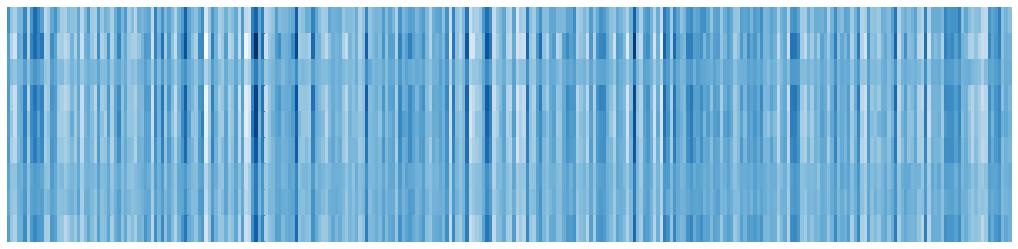

In [27]:
%matplotlib inline

def show(embedding):
    w = 18
    h = embedding.shape[0] * (w / 300) * 8

    fig = plt.figure(figsize=(w, h))
    ax = fig.add_subplot(1, 1, 1)

    print(embedding.shape)
    sns.heatmap(pd.DataFrame(embedding), cbar=False, xticklabels=False, yticklabels=False, cmap='Blues')

    plt.show()
    return

df = pd.DataFrame(X_train)
show(df.groupby(y_train).mean())

ベンチマーク；SVM で 82 %

In [28]:
from sklearn.svm import SVC

model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

sum(y_pred == y_test) / len(y_test)

0.8268839103869654

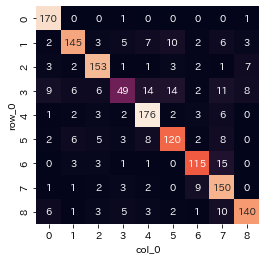

In [29]:
%matplotlib inline

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
sns.heatmap(pd.crosstab(y_test, y_pred), cbar=False, annot=True, fmt='d')
plt.show()

# Work

In [ ]:
%%time
# embed
wv = KeyedVectors.load_word2vec_format('/data/chive/chive-1.2-mc5/chive-1.2-mc5.txt')
wv